### Nonlinear Function

Given a $\phi$ and $\phi^{-1}$ (trained in Quantum autoencoder) such that $\phi^{-1}\circ\phi|\alpha\rangle = |\alpha\rangle$ and $dim(\phi|\alpha\rangle) < dim(|\alpha\rangle)$, we want to find a function $f$ such that $\phi^{-1}\circ f\circ\phi|\alpha_k\rangle = |\alpha_{k+1}\rangle$.

In [1]:
import matplotlib.pyplot as plt         
import tensorflow as tf
import numpy as np
import os
import pandas as pd

import sys

sys.path.append('..')
from utils import *
sys.path.remove('..')


#Some GPU configuration
#Always uses the 1st GPU avalible (if avalible) unless 1st line is uncommented, in which case no GPU is used

#tf.config.set_visible_devices([], 'GPU') #uncomment to set tensorflow to use CPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
elif len(physical_devices) == 0:
    print("Warning: No GPU detected.  Running tensorflow on CPU")

In [2]:
Phi = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial25e1000Phi.h5', compile=False)
Phi_inv = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial25e1000Phi_inv.h5', compile=False)

In [3]:
def L2_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord=2, axis=-1)

def L2_with_unity_loss(y_true, y_pred):
    '''L2 loss augmented with extra loss for not having a norm of 1'''
    return tf.norm(y_true-y_pred, ord=2, axis=-1) + tf.abs(1. - tf.norm(y_pred, ord=2, axis=-1))

def ideal_phi_3D(state):
    assert (len(state)==4),'State must be 4 dimensions to compress to 3'
    r1 = np.sqrt(state[0]*state[0] + state[1]*state[1])
    r2 = np.sqrt(state[2]*state[2]+state[3]*state[3])
    phi1 = np.math.atan2(state[1],state[0])
    phi2 = np.math.atan2(state[3],state[2])
    return np.array([r1, r2, phi2-phi1])

def ideal_phi_3D_inv(state):
    assert (len(state) == 3),'Compressed state must be 3 dimensions to be decompressed'
    alpha = state[0]
    beta = 0.
    gamma = state[1]*np.cos(state[2])
    delta = state[1]*np.sin(state[2])
    return np.array([alpha, beta, gamma, delta])

In [4]:
#Train on entire evolutions, not just step-to-step?
def get_multiple_evolutions(datadir, num_evolutions, train_evolutions, ideal_pre_compress_3D=False, pre_compress_phi=False):
    '''Read in the evolution of multiple initial conditions at once.  Each initial condition should 
    have its own csv file and be named in the format "evolution{}.csv", where {} indicates an integer.
    Note that there will be 1 fewer timesteps per evolution file than are present in the evolution file,
    since the last step does not have an evolution.
    
    PARAMS:
    -------
    str datadir: Path to directory containing evolution files.
    int num_evolutions: The number of initial conditions to read in.
    int train_evolutions: The number of initial conditions that should be treated as 
                          training evolutions
    
    RETURNS:
    --------
    (tf.data.Dataset, tf.data.Dataset): A tuple of the training and validation datasets, respectivley.
    '''
    
    pre_evolution = []
    post_evolution = []
    
    #Read training data
    for i in range(train_evolutions):

        with open(datadir+'evolution{}.csv'.format(i), 'r') as f:
            data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
            
            if ideal_pre_compress_3D:
                data = [ideal_phi_3D(x) for x in data]
            elif pre_compress_phi:
                data = Phi(data)
            
            pre_evolution.append(data[0])
            
            for k in data[1:-1]:
                pre_evolution.append(k)
                post_evolution.append(k)
            
            post_evolution.append(data[-1])
        

        train = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))

                
    
    
    #Read test data
    pre_evolution = []
    post_evolution = []
    
    for i in range(train_evolutions, num_evolutions):


        with open(datadir+'evolution{}.csv'.format(i), 'r') as f:
            data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
            
            if ideal_pre_compress_3D:
                data = [ideal_phi_3D(x) for x in data]
            elif pre_compress_phi:
                data = Phi(data)
            
            
            pre_evolution.append(data[0])
            
            for k in data[1:-1]:
                pre_evolution.append(k)
                post_evolution.append(k)
            
            post_evolution.append(data[-1])
            
            


        test = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
      
    
    #return train, test
    return train.shuffle(1000000, reshuffle_each_iteration=True), test.shuffle(1000000, reshuffle_each_iteration=True)
    
    
#We never train on just a single evolution anymore
def get_evolution_data(evolution_data):
    '''Read in evolution data from a csv file
    
    PARAMS:
    -------
    str evolution_data: Path to evolution datafile we wish to read
    bool ideal_pre_comrpess_3D: If true, uses ideal compression functions to 
                                  compress evolution data into specified dimension
    bool pre_compress_phi: If true, use the Phi neural net model to compress
                           evolution data
    
    RETURNS:
    --------
    tf.data.Dataset: Shuffled dataset of evolution values
    '''

    evolution_file = evolution_data

    data = tf.data.experimental.CsvDataset(evolution_file, [tf.float32, tf.float32, tf.float32], select_cols=[1,2,3], header=True)
    
    data = data.map(lambda a,b,c: tf.stack([a,b,c]))


        
    pre_evolution = data.take(data.cardinality()-1)
    post_evolution = data.skip(1).take(data.cardinality()-1)
    
    ds = tf.data.Dataset.zip((pre_evolution, post_evolution))
            
    return ds
    #return ds.shuffle(1000000, reshuffle_each_iteration=True)
    

#Seems to sit at about 2s/step for larger datasets
def interleave_test(datadir, max_evolution, training_evolutions, pre_compress_phi=True):
    training_filenames = [datadir+'evolution{}.csv'.format(x) for x in range(training_evolutions)]
    training_files = tf.data.Dataset.from_tensor_slices(training_filenames)
    validation_filenames = [datadir+'evolution{}'.format(x) for x in range(training_evolutions, max_evolution)]
    validation_files = tf.data.Dataset.from_tensor_slices(validation_filenames)
    training_files = training_files.interleave(lambda x: get_evolution_data(x), num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000000, reshuffle_each_iteration=True)
    validation_files = validation_files.interleave(lambda x:get_evolution_data(x), num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000000, reshuffle_each_iteration=True)
    return training_files,validation_files 
         
                
def read_single_file(file, num_evolutions, steps_per_evolution):
    
    data = tf.data.experimental.CsvDataset(file, [tf.float32, tf.float32, tf.float32], select_cols=[1,2,3], header=True)
    
    data = data.map(lambda a,b,c: tf.stack([a,b,c]))
    
    pre_evolution = data.take(num_evolutions*steps_per_evolution - 1)
    post_evolution = data.skip(1).take(num_evolutions*steps_per_evolution - 1)
    
    ds = tf.data.Dataset.zip((pre_evolution, post_evolution))
    
    return ds.shuffle(1000000, reshuffle_each_iteration = True)

In [11]:
#import tensorflow_datasets as tfds
test, val = interleave_test('../../QuantumTeam/data/50000inits_dt0p1_compressed/', 20000, 18000)
test = test.batch(100000).prefetch(tf.data.experimental.AUTOTUNE)
val = val.batch(100000).prefetch(2)
#bench = tfds.benchmark(test, num_iter=10, batch_size=100000)
#test = read_single_file('../../QuantumTeam/data/master_test.csv', 10000, 500)
#test = test.batch(100000)

In [67]:

#train, val = get_multiple_evolutions('../../QuantumTeam/data/50000inits_dt0p1_compressed/',1000, 800)
#train = train.batch(100000)
#val = val.batch(100000)
#test = interleave_test('../../QuantumTeam/data/50000inits_dt0p1/', 500, 450, pre_compress_phi=True)
#bench = tfds.benchmark(train, num_iter=10, batch_size=10000)

 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 29495.60 ex/sec (total: 40000 ex, 1.36 sec)
Examples/sec (First only) 21248.73 ex/sec (total: 10000 ex, 0.47 sec)
Examples/sec (First excluded) 33878.47 ex/sec (total: 30000 ex, 0.89 sec)


In [7]:
inputs = tf.keras.Input(shape=3)


nonlinear_layer_1 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_1')(inputs)
nonlinear_layer_2 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_2')(nonlinear_layer_1)
nonlinear_layer_3 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_3')(nonlinear_layer_2)
nonlinear_layer_4 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_4')(nonlinear_layer_3)
nonlinear_layer_5 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_5')(nonlinear_layer_4)
nonlinear_layer_6 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_6')(nonlinear_layer_5)
evolved = tf.keras.layers.Dense(3, activation='selu', name='evolved_state_layer')(nonlinear_layer_6)

NonlinearEvolution = tf.keras.Model(inputs=inputs, outputs=evolved)

In [8]:
NonlinearEvolution.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=L2_loss, metrics=['mse', 'mae'])

In [ ]:
%%time
history = NonlinearEvolution.fit(test, epochs=5)

In [11]:
write_history(history, NonlinearEvolution,loss='L2_loss',batch_size='100000', other_info={'dataset':'50000inits_dt0p1 (First 5000 evolutions)','validation':'500inits'})

'./datafiles/trial40.data'

In [10]:
append_history(history, params={'Learning Rate':.0001})

In [182]:
NonlinearEvolution.save('./models/trial39e500.h5')

In [6]:
NonlinearEvolution = tf.keras.models.load_model('./dataspace_tests/tests/dt0p1_tests/0t50/models/50000inits_dt0p1.h5', compile=False)

In [12]:
note_history(35,'./datafiles/', 'Only the first 2000 inits were used')

In [ ]:
loss_plot('./dataspace_tests/dt0p1_tests/0t10/datafiles/0t10_dt0p1_15000inits.data', savefig=False, skip_epochs=10, mark_lowest=False)

## Visualizations

In [7]:
def predict_single_timestep(state, ideal_compression_3D=False, compression_phi=True, decompression_phi_inv=True, NonlinearEvolution=NonlinearEvolution):

    if ideal_compression_3D:
        assert (len(state) == 4), "State must be a four dimensional vector to be compressed"
        state = ideal_phi_3D(state)
        return ideal_phi_3D_inv(NonlinearEvolution(np.array([state,])).numpy()[0])
    if compression_phi:
        assert (len(state) == 4), "State must be a four dimensional vector to be compressed"
        state = Phi(np.array([state,]))
        if decompression_phi_inv:
            return Phi_inv(NonlinearEvolution(state)).numpy()[0]
        else:
            return NonlinearEvolution(state).numpy()[0]
    
    assert (len(state)==3), "State must be three dimensional if not being compressed"
        
    return NonlinearEvolution(np.array([state,])).numpy()[0]
    

In [9]:
import qutip as qt


def predict_evolution(initial_cond, save_prediction=False, save_compressed=False, 
                      saved_name='./predicted_evolutions/newtest.csv', 
                      saved_compressed_name='./predicted_evolutions/newtest_compressed.csv', 
                      timesteps=1000, NonlinearEvolution=NonlinearEvolution):
    '''Use the currently loaded NonlinearF to predict an evolution
    given an initial condition.  The initial condition is compressed using Phi
    and the state is then evolved for the specified number of timesteps by NonlinearF
    without any decompression between steps.  Each evolved state is then decompressed seperatley.
    
    PARAMS:
    -------
    str initial_cond: Path to file containing initial condition (read as first point in a csv)
    list initial_cond: The initial condition to evolve
    bool save_prediction: Whether or not to save the prediction
    str saved_name: Name/path to file containing predicted evolution (if save_prediction is True)
    bool save_compressed: Whether or not to save the evolution before it is decompressed
    str save_compressed_name: Name/path to file containing compressed evolution prediction
    int timesteps: Number of timesteps to evolve for
    '''
    
    if type(initial_cond) == str:
        initial_cond = np.genfromtxt(initial_cond, delimiter=',', skip_header=1)[0,1:]
    
    if len(initial_cond)==4:
        initial_cond=Phi(np.array([initial_cond,])).numpy()[0]
    
    learned_evolution=np.empty([timesteps, 3])
    learned_evolution[0] = initial_cond
    
    for i in range(1,timesteps):
        learned_evolution[i] = predict_single_timestep(learned_evolution[i-1], compression_phi=False, decompression_phi_inv=False, NonlinearEvolution=NonlinearEvolution)
    
    if save_compressed:
        pd.DataFrame(learned_evolution).to_csv(saved_compressed_name)
    
    learned_evolution=Phi_inv(learned_evolution).numpy()
    
    if save_prediction:
        pd.DataFrame(learned_evolution).to_csv(saved_name)
        
    return learned_evolution


#TODO - change all the boolean switches into a dictionary for selection
def plot_dynamics(truth, predicted, savefig=False, timerange=500, timestart=0,
                  phispace=False, truespace=False, expectation=False, figname='dynamics.png', 
                  fontsize=16):
    '''Plot the dynamics (or state) of some evolution.  
    
    PARAMS:
    -------
    np.array truth,predicted: The true evolution and the predicted evolution.  Should be read from
                              a csv generated by pd.DataFrame with np.genfromtxt, or have an otherwise
                              identical structure to such an array
    bool phispace, truespace, expectation: Selects which space to plot.  Truespace refers to the 
                                           uncompressed 4 dimensional space which the Bloch sphere lives in, 
                                           phispace refers to the space in which NonlinearF learns its dynamics.
                                           Expectation refers to the space which QuTip uses to plot points on the 
                                           Bloch sphere.  If all of these are set to False, default to plotting the 
                                           'ideal' compressed space (r1, r2, relative phase).
    '''
    
    FONTSIZE=fontsize
    plt.rc('font', size=FONTSIZE)
    plt.rc('axes', titlesize=FONTSIZE,labelsize=FONTSIZE)
    plt.rc('legend', fontsize=FONTSIZE)
    plt.rc('xtick', labelsize=FONTSIZE)
    plt.rc('ytick', labelsize=FONTSIZE)
    plt.rc('figure', titlesize=FONTSIZE)
    
    
    
    if truespace:
        fig, ax = plt.subplots(4,1,figsize=(18,32))
        
        ax[0].plot(truth[timestart:timerange,0], truth[timestart:timerange,1], label='True')
        ax[0].plot(predicted[timestart:timerange,0], predicted[timestart:timerange,1], ls='--', label='Predicted')
        
        ax[1].plot(truth[timestart:timerange,0], truth[timestart:timerange,2])
        ax[1].plot(predicted[timestart:timerange,0], predicted[timestart:timerange,2], ls='--')
        
        ax[2].plot(truth[timestart:timerange,0], truth[timestart:timerange,3])
        ax[2].plot(predicted[timestart:timerange,0], predicted[timestart:timerange,3], ls='--')
        
        ax[3].plot(truth[timestart:timerange,0], truth[timestart:timerange,4])
        ax[3].plot(predicted[timestart:timerange,0], predicted[timestart:timerange,4], ls='--')
        
        ax[0].legend()
        ax[0].set_title(r'$\alpha$')
        ax[1].set_title(r'$\beta$')
        ax[2].set_title(r'$\gamma$')
        ax[3].set_title(r'$\delta$')
        ax[3].set_xlabel('Timestep')
        
    elif expectation:
        fig, ax = plt.subplots(3,1, figsize=(18,24))

        xs = []
        ys = []
        zs = []

        xspred = []
        yspred = []
        zspred = []

        for i in range(timestart, timerange):
            state = np.array([truth[i,1]+truth[i,2]*1j, truth[i,3]+truth[i,4]*1j])
            state = qt.Qobj(state)

            predstate = np.array([predicted[i,1] + predicted[i,2]*1j, predicted[i,3] + predicted[i,4]*1j])
            predstate = qt.Qobj(predstate)

            for t in [state]:
                xs.append(qt.expect(qt.sigmax(), t))
                ys.append(qt.expect(qt.sigmay(), t))
                zs.append(qt.expect(qt.sigmaz(), t))


            for t in [predstate]:
                xspred.append(qt.expect(qt.sigmax(), t))
                yspred.append(qt.expect(qt.sigmay(), t))
                zspred.append(qt.expect(qt.sigmaz(), t))


        ax[0].plot(np.arange(timestart,timerange), xs)
        ax[1].plot(np.arange(timestart,timerange), ys)
        ax[2].plot(np.arange(timestart,timerange), zs)

        ax[0].plot(np.arange(timestart,timerange), xspred)
        ax[1].plot(np.arange(timestart,timerange), yspred)
        ax[2].plot(np.arange(timestart,timerange), zspred)

        ax[0].set_title(r'$\langle\psi|\hat{\sigma_x}|\psi\rangle$')
        ax[1].set_title(r'$\langle\psi|\hat{\sigma_y}|\psi\rangle$')
        ax[2].set_title(r'$\langle\psi|\hat{\sigma_z}|\psi\rangle$')
    
    elif not phispace:
        fig, ax = plt.subplots(3,1,figsize=(18,24))
        
        
        r1 = np.sqrt(truth[timestart:timerange,1]**2 + truth[timestart:timerange,2]**2)
        r2 = np.sqrt(truth[timestart:timerange,3]**2 + truth[timestart:timerange,4]**2)
        theta = np.arctan2(truth[timestart:timerange,4],truth[timestart:timerange,3]) - np.arctan2(truth[timestart:timerange,2],truth[timestart:timerange,1])

        r1l = np.sqrt(predicted[timestart:timerange,1]**2 + predicted[timestart:timerange,2]**2)
        r2l = np.sqrt(predicted[timestart:timerange,3]**2 + predicted[timestart:timerange,4]**2)
        thetal = np.arctan2(predicted[timestart:timerange,4],predicted[timestart:timerange,3]) - np.arctan2(predicted[timestart:timerange,2],predicted[timestart:timerange,1])
        
        ax[0].plot(truth[timestart:timerange,0], r1, label='True')
        ax[0].plot(predicted[timestart:timerange,0], r1l, ls='--', label='Predicted')

        ax[1].plot(truth[timestart:timerange,0],r2)
        ax[1].plot(predicted[timestart:timerange,0],r2l, ls='--')

        ax[2].plot(truth[timestart:timerange,0],theta)
        ax[2].plot(predicted[timestart:timerange,0],thetal, ls='--')

        ax[0].legend()
        ax[0].set_title(r'$r_1 = \sqrt{\alpha^2+\beta^2}$')
        ax[1].set_title(r'$r_2 = \sqrt{\gamma^2+\delta^2}$')
        ax[2].set_title(r'$\theta = \arctan\left(\frac{\delta}{\gamma}\right) - \arctan\left(\frac{\beta}{\alpha}\right)$')

        ax[2].set_xlabel('Timestep')
        
        
    else:
        fig, ax = plt.subplots(3,1,figsize=(18,24))
        
        
        compressed_truth = Phi(truth[:,1:]).numpy()
        compressed_pred = Phi(predicted[:,1:]).numpy()

        ax[0].plot(truth[timestart:timerange,0], compressed_truth[timestart:timerange,0], label='True')
        ax[0].plot(predicted[timestart:timerange,0], compressed_pred[timestart:timerange,0], ls='--',label='Predicted')

        ax[1].plot(truth[timestart:timerange,0],compressed_truth[timestart:timerange,1])
        ax[1].plot(predicted[timestart:timerange,0],compressed_pred[timestart:timerange,1], ls='--')

        ax[2].plot(truth[timestart:timerange,0],compressed_truth[timestart:timerange,2])
        ax[2].plot(predicted[timestart:timerange,0],compressed_pred[timestart:timerange,2], ls='--')

        ax[0].legend()
        ax[0].set_title(r'$\phi|\alpha\rangle[0]$')
        ax[1].set_title(r'$\phi|\alpha\rangle[1]$')
        ax[2].set_title(r'$\phi|\alpha\rangle[2]$')
        ax[2].set_xlabel('Timestep')
        
    if savefig:
        fig.savefig(figname, bbox_inches='tight', transparent=False)
        
    
        
#Create images to be used for animations of the evolution
#VERY SLOW, took about an hour to create 1000 images on my laptop

#After running, use ffmpeg to stitch the frames together (wrapped inside create_animation.sh)

def create_animation_frames(truth, predicted, framedir='./anim/', timesteps=500, view=[-60,30]):

    b = qt.Bloch()
    
    b.view = view

    b.vector_color = ['g', '#000000']
    b.point_color = ['g', '#000000']
    b.point_marker = ['o']


    for i in range(timesteps):
    
        #Clear vectors, keep points
        b.vectors = []

        #Plot true evolution in green

        state = np.array([truth[i,1]+truth[i,2]*1j, truth[i,3]+truth[i,4]*1j])
        state = qt.Qobj(state)
        b.add_states([state])
        b.add_states([state], kind='point')


        #Plot learned evolution in black

        state = np.array([predicted[i,1]+predicted[i,2]*1j, predicted[i,3]+predicted[i,4]*1j])
        state = qt.Qobj(state)
        b.add_states([state])
        b.add_states([state], kind='point')
        
        b.save(dirc=framedir)
        
def predict_and_load(initial_condition_file, timerange, timestep, inits, save_prediction=True, 
                     saved_name=None, save_compressed=True, saved_compressed_name=None, 
                     timesteps=1000, modeldir=None, prediction_dir='./predicted_evolutions/',
                     load_prediction=True):
    if modeldir==None:
        modeldir = './dataspace_tests/models/'
    
    NonlinearEvolution = tf.keras.models.load_model(modeldir+'0t{}_dt{}_{}inits.h5'.format(timerange,str(timestep).replace('.','p'),inits), compile=False)
    if not load_prediction:
        return NonlinearEvolution
    
    if os.path.exists(prediction_dir+'0t{}_dt{}_{}inits.csv'.format(timerange,str(timestep).replace('.','p'),inits)):
        data = np.genfromtxt(initial_condition_file, delimiter=",", skip_header=1)
        learned = np.genfromtxt(prediction_dir+'0t{}_dt{}_{}inits.csv'.format(timerange,str(timestep).replace('.','p'),inits), delimiter=',', skip_header=1)
        return NonlinearEvolution, data, learned
    else:
        if save_prediction==True and saved_name==None:
            saved_name = prediction_dir+'0t{}_dt{}_{}inits.csv'.format(timerange,str(timestep).replace('.','p'),inits)
        if save_compressed==True and saved_compressed_name==None:
            saved_compressed_name = prediction_dir+'0t{}_dt{}_{}inits_compressed.csv'.format(timerange,str(timestep).replace('.','p'),inits)
        predict_evolution(initial_condition_file, save_prediction=save_prediction, saved_name=saved_name, save_compressed=save_compressed, saved_compressed_name=saved_compressed_name, timesteps=timesteps, NonlinearEvolution=NonlinearEvolution)
        data = np.genfromtxt(initial_condition_file, delimiter=",", skip_header=1)
        learned = np.genfromtxt(saved_name, delimiter=',', skip_header=1)
        return NonlinearEvolution, data, learned
        

In [10]:
NonlinearEvolution, data, learned = predict_and_load('../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv', 10, 0.1, 5000)

In [92]:
predict_evolution('../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv', save_prediction=True, saved_name='./predicted_evolutions/0t50_dt0p1_50000inits.csv', save_compressed=True, saved_compressed_name='./predicted_evolutions/0t50_dt0p1_50000inits.csv', timesteps=5000)

array([[ 1.0007367 ,  0.0028226 ,  0.00116147,  0.00240916],
       [ 0.99017954, -0.05752831, -0.08335832, -0.09629864],
       [ 0.96085274, -0.1107166 , -0.17087327, -0.18135048],
       ...,
       [ 0.5598208 , -0.5855723 ,  0.40094978, -0.4265623 ],
       [ 0.5112656 , -0.68034476,  0.2977346 , -0.43426234],
       [ 0.44918334, -0.765491  ,  0.18269885, -0.42276573]],
      dtype=float32)

In [93]:
#Read in evolution data for plotting 
data = np.genfromtxt("../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv", delimiter=",", skip_header=1)
learned = np.genfromtxt('./predicted_evolutions/0t50_dt0p1_50000inits.csv', delimiter=",", skip_header=1)

In [21]:
#Check that magnitude is approximately 1
timerange=1000
r1l = np.sqrt(learned[:timerange,1]**2 + learned[:timerange,2]**2)
r2l = np.sqrt(learned[:timerange,3]**2 + learned[:timerange,4]**2)
thetal = np.arctan2(learned[:timerange,4],learned[:timerange,3]) - np.arctan2(learned[:timerange,2],learned[:timerange,1])

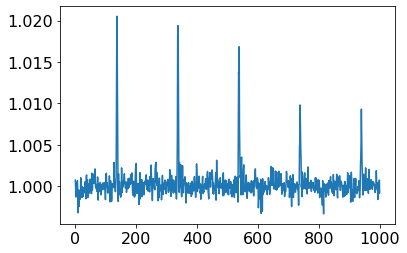

In [22]:
plt.plot(learned[:1000,0], np.sqrt(r1l[:1000]**2+r2l[:1000]**2))

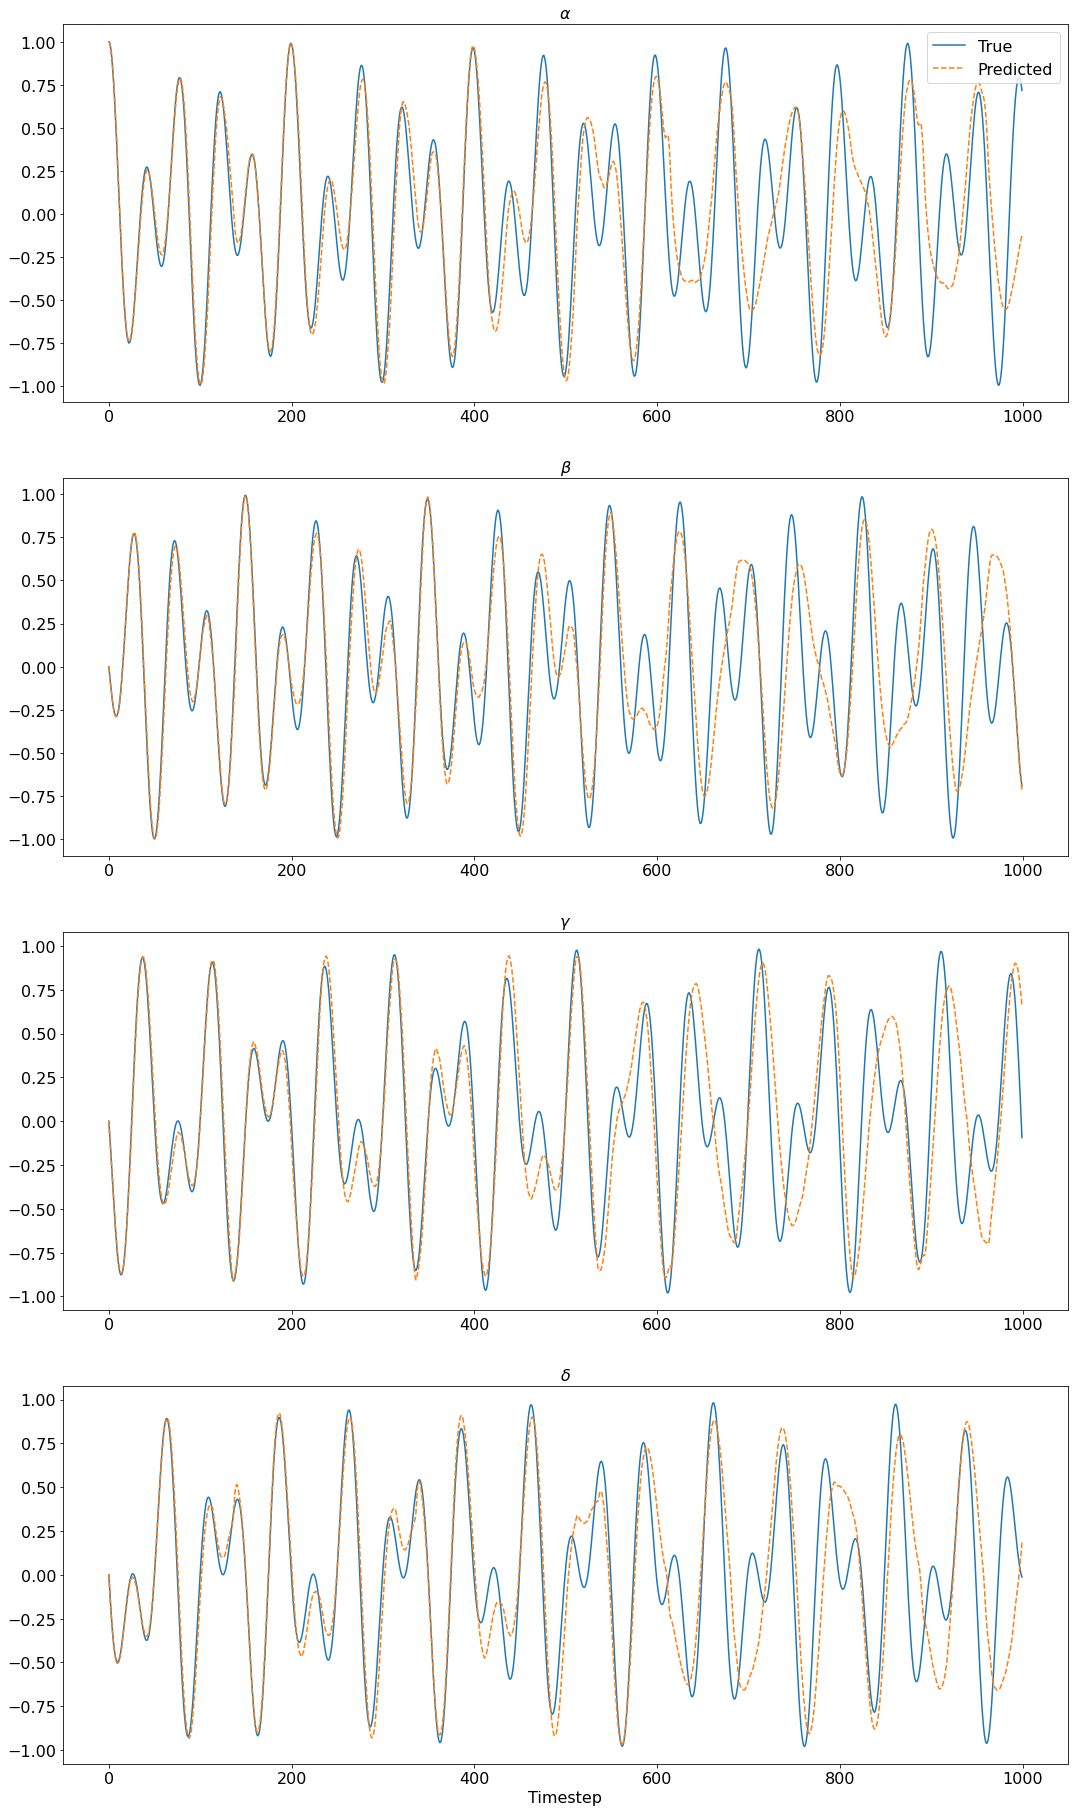

In [11]:
plot_dynamics(data, learned, phispace=False, truespace=True, expectation=False, savefig=False,figname='./figures/trial36_ts4t5000.png', timerange=1000, timestart=0)

In [ ]:
create_animation_frames(data, learned, timesteps=1000)

<ipython-input-21-bdc930261258>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch.add_vectors(np.array([procession_x, procession_y, procession_z], dtype=np.float64))


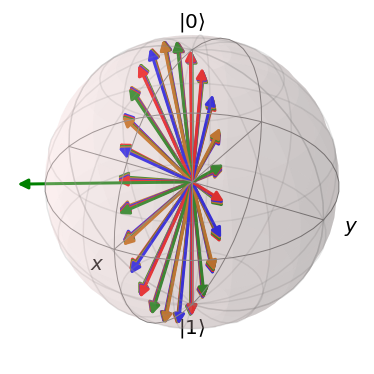

In [21]:
#The actual evolution

bloch = qt.Bloch()

for i in range(100):
    state = np.array([data[i,1]+data[i,2]*1j, data[i,3]+data[i,4]*1j])
    bit=qt.Qobj(state)
    bloch.add_states([bit])
    
    
ham=np.array([[0.5566942775987375+0*1j, 0.9560186831757848+0.784645945006308j],[0.9560186831757848-0.784645945006308j,0.0872675534068238+0*1j]])
procession_z = 0.5*(ham[0,0]-ham[1,1])
procession_y = -0.5j*(ham[1,0]-ham[0,1])
procession_x = 0.5*(ham[1,0]+ham[0,1])



bloch.add_vectors(np.array([procession_x, procession_y, procession_z], dtype=np.float64))
    
bloch.render()

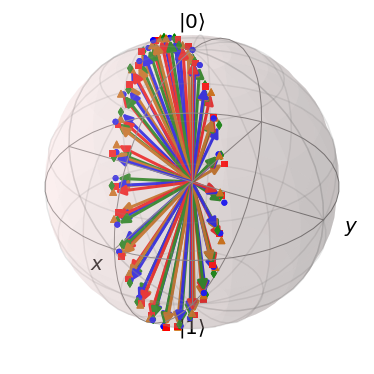

In [39]:
#The predicted evolution

bloch = qt.Bloch()

for i in range(100):
    state = np.array([learned[i,1]+learned[i,2]*1j, learned[i,3]+learned[i,4]*1j])
    bit=qt.Qobj(state)
    bloch.add_states([bit])
    bloch.add_states([bit], kind='point')
    
bloch.render()

[-0.32997028 -0.80155016 -0.49525556 -0.05795593]
[0.86681200083622, 0.0, 0.24212193525470418, -0.435905865611861]
0.8668120008362199 0.49863509223309677
0.86681200083622 0.4986350922330968
(0.9560186831757848+0j)
(-0.784645945006308+0j)
(0.23471336209595683+0j)
[ 0.95601868 -0.78464595  0.23471336]


<ipython-input-18-3b49fe80210b>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  b.add_vectors(np.array([procession_x, procession_y, procession_z], dtype=np.float64))
<ipython-input-18-3b49fe80210b>:42: ComplexWarning: Casting complex values to real discards the imaginary part
  print(np.array([procession_x, procession_y, procession_z], dtype=np.float64))


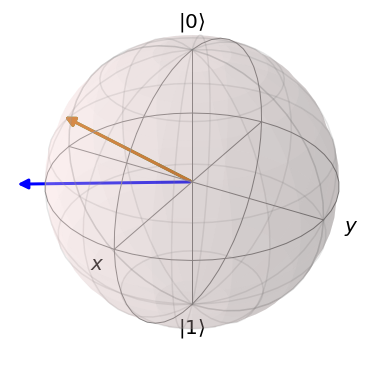

In [18]:
vec = np.random.randn(4)
vec = 1/np.linalg.norm(vec) * vec

vectilde = [0.,0.,0.,0.]

r1 = np.sqrt(vec[0]**2 + vec[1]**2)
r2 = np.sqrt(vec[2]**2+vec[3]**2)

phi = np.arctan2(r2,r1)
theta = np.arctan2(vec[3],vec[2]) - np.arctan2(vec[1],vec[0])

vectilde[0] = np.cos(phi)
vectilde[1] = 0.
vectilde[2] = np.cos(theta)*np.sin(phi)
vectilde[3] = np.sin(theta)*np.sin(phi)

print(vec)
print(vectilde)

print(np.sqrt(vec[0]**2+vec[1]**2),np.sqrt(vec[2]**2+vec[3]**2))
print(np.sqrt(vectilde[0]**2+vectilde[1]**2),np.sqrt(vectilde[2]**2+vectilde[3]**2))

b = qt.Bloch()

state = qt.Qobj(np.array([vec[0]+vec[1]*1j, vec[2]+vec[3]*1j]))
statetilde = qt.Qobj(np.array([vectilde[0]+vectilde[1]*1j, vectilde[2]+vectilde[3]*1j]))

b.add_states([state])
b.add_states([statetilde])

ham=np.array([[0.5566942775987375+0*1j, 0.9560186831757848+0.784645945006308j],[0.9560186831757848-0.784645945006308j,0.0872675534068238+0*1j]])
procession_z = 0.5*(ham[0,0]-ham[1,1])
procession_y = -0.5j*(ham[1,0]-ham[0,1])
procession_x = 0.5*(ham[1,0]+ham[0,1])



b.add_vectors(np.array([procession_x, procession_y, procession_z], dtype=np.float64))
print(procession_x)
print(procession_y)
print(procession_z)
print(np.array([procession_x, procession_y, procession_z], dtype=np.float64))
b.render()

In [ ]:
b = qt.Bloch()
b.point_color=['g']
b.point_marker=['o']


for i in range(100):
    with open('../../QuantumTeam/data/5000inits_dt0p1/evolution{}.csv'.format(i), 'r') as f:
        for k in f.readlines()[1:300]:
            i = [float(x) for x in k.strip().split(',')[1:]]
            state = np.array([i[0]+i[1]*1j, i[2]+i[3]*1j])
            bit = qt.Qobj(state)
            b.add_states([bit], kind='point')
            #print(k.strip().split(','))
            
b.render()

## Evolution Quality Metric

Several metrics for measuring the quality of an evolution beyond just eyeballing it.

- $max\|\phi^{-1}\circ F\circ\phi(\alpha(a+b)) - \left(\alpha\phi^{-1}\circ F\circ\phi(a)+\alpha\phi^{-1}\circ F\circ\phi(b)\right)\|_2$
    - This metric is better the smaller it is.  Ideally, we should be able to recover the linearity of the Schroedinger equation.
    - a and b are randomly sampled on the Bloch sphere.  $\alpha$ is chosen such that $a+b$ is also on the Bloch sphere.
    - Maybe do average instead of max?
    
- Validation loss normalized with timestep
    - Essentially interprets as if our loss were to stay constant, how far off would we be from the true evolution after 1 unit of time?

In [20]:
def dataset_integrity_check(datadir, timerange, timestep):
    timestep = str(timestep).replace('.','p')
    datafiles = datadir+'dt{}_tests/0t{}/datafiles/'.format(timestep, timerange)
    for file in os.listdir(datafiles):
        with open(datafiles+file, 'r') as f:
            if (f.readlines()[1].strip().split(',')[-1]) == '':
                print('Check '+file)

def linear_recovery_metric(num_test_points, average=False, timerange=-1, timestep=-1, num_inits=-1):
    
    
    if (timerange, timestep, num_inits) != (-1,-1,-1):
        NonlinearEvolution = predict_and_load(None, timerange, timestep, num_inits, load_prediction=False)
    
    max_diff = 0
    avg = 0
    samples = np.empty([num_test_points])
    for i in range(num_test_points):
        a = np.random.randn(4)
        a = 1/np.linalg.norm(a) * a
        b = np.random.randn(4)
        b = 1/np.linalg.norm(b) * b
        
        alpha = 1/np.linalg.norm(a+b)
        apb = alpha * (a+b)
        
        aencode = Phi(np.array([a,])).numpy()[0]
        bencode = Phi(np.array([b,])).numpy()[0]
        apbencode = Phi(np.array([apb,])).numpy()[0]
        
        Fapb = NonlinearEvolution(np.array([apbencode,])).numpy()[0]
        apb_evolved = Phi_inv(np.array([Fapb,])).numpy()[0]
        
        Fa = NonlinearEvolution(np.array([aencode,])).numpy()[0]
        a_evolved = Phi_inv(np.array([Fa,])).numpy()[0]
        
        Fb = NonlinearEvolution(np.array([bencode,])).numpy()[0]
        b_evolved = Phi_inv(np.array([Fb,])).numpy()[0]
        
        linear_diff = np.linalg.norm(apb_evolved - alpha*(a_evolved+b_evolved))
        
        if linear_diff > max_diff:
            max_diff = linear_diff
        if average==True:
            avg+=linear_diff
            samples[i] = linear_diff
    
    if average==True:
        avg = avg/num_test_points
        variance = np.sum((samples-avg)**2) / (num_test_points-1)
        return avg, np.sqrt(variance)
    else:
        return max_diff
    
#This metric essentially means that our prediction will deviate from
##the true value by normalized_val_loss per unit of time
def normalized_val_loss(datafile, timestep):
    val_losses = []
    with open(datafile, 'r') as f:
        for line in f.readlines():
            if line.strip().split(',')[0] == 'val_loss':
                val_losses = [float(x) for x in line.strip().split(',')[1:]]
    
    return min(val_losses)/timestep

Some metrics for the dataset itself.  Not entirley convinced the spatial density test is working yet, but the temporal one should be.

The spatial density test essentially slices the Bloch sphere through a plane which the axis of procession lies in.  This creates a circle, though we only worry about the upper arc.  We then check the spacing of the evolutions on that arc.  We only need to load in a single point from each evolution, the function 'completes' the evolution by projecting the points onto the procession axis and then re-projecting them back onto the arc, essentially just lining all the points up.

The temporal density test takes some evolution and moves its frame to be in the plane which the evolution lies in.  It then defines the initial condition as the 'zero angle' and measures the angle all the other evolution points relative to the zero angle.  This gives an idea of the spacing of the points in the evolution (though two points which are next to each other on the Bloch sphere may not be next to each other in the evolution; our sampling rate will cause each evolution to be offset slightly from the previous).

In [107]:
def dataset_spatial_density(dataset, num_evolutions, ham, pretty_print=True):
    
    #if type(ham) == str:
    #    ham = np.genfromtxt(ham, delimiter=',', skip_header=1)[:,1:]
    
    
    #Gives axis of rotation on Bloch sphere
    ##Derived from eq. 16.104 in Merzbacher
    procession_z = 0.5*(ham[0,0]-ham[1,1])
    procession_y = -0.5j*(ham[1,0]-ham[0,1])
    procession_x = 0.5*(ham[1,0]+ham[0,1])
    
    procession_axis = np.real(np.array([procession_x, procession_y, procession_z]))
    procession_axis = 1/np.linalg.norm(procession_axis) * procession_axis
    
    
    #Read in 1 point from every evolution as a quantum state
    points = np.empty([num_evolutions,4])
    for i in range(num_evolutions):
        points[i] = np.genfromtxt(dataset+'evolution{}.csv'.format(i), skip_header=1, delimiter=',')[0,1:]
    
    #Get the spherical representation of the points
    ##Theta is relative phase, phi is 'angle between' the probabilities
    r1s = np.sqrt(points[:,0]**2 + points[:,1]**2)
    r2s = np.sqrt(points[:,2]**2 + points[:,3]**2)
    phis = np.arctan2(r2s,r1s)
    thetas = np.arctan2(points[:,3],points[:,2]) - np.arctan2(points[:,1],points[:,0])
    
    #Project spherical coords onto cartesian axes
    states_x = np.cos(thetas)*np.sin(phis)
    states_y = np.sin(thetas)*np.sin(phis)
    states_z = np.cos(phis)
    
    '''
    #Same thing as above, but relies on QuTip for the projections
    ##Slower and has extra dependencies
    states = []
    for i in range(num_evolutions):
        point = np.genfromtxt(dataset+'evolution{}.csv'.format(i), skip_header=1, delimiter=',')[0,1:]
        up = point[0]+point[1]*1j
        down = point[2]+point[3]*1j
        states.append(qt.Qobj(np.array([up,down])))
        
    #Find the representation of each point in xyz space where the procession axis is
    
    #qt.expect always returns a complex type even though our states will be pure real
    ##since the Pauli matrices are Hermetian.  Just convert real for type convinience   
    states_x = np.real(qt.expect(qt.sigmax(), states))
    states_y = np.real(qt.expect(qt.sigmay(), states))
    states_z = np.real(qt.expect(qt.sigmaz(), states))
    '''
    states_xyz = np.column_stack((states_x, states_y, states_z))

    
    #Project each state onto the axis of rotation
    ##Just getting the scalar projection, don't really care about the 
    ##specific direction of the projected vector
    projections = np.inner(procession_axis, states_xyz)
    
    
    
    #Projections are on (flat) axis of procession, but the evolutions exist on a sphere
    ##The flat projection will artificially cause points to 'bunch up' near the ends
    ##giving the appearance of high density even if the points are evenly spaced on the 
    ##sphere.  So we convert the points on this projected axis into angles of the corresponding
    ##position on the arc
    arc_angles = np.arccos(projections)
    
    arc_angles = np.sort(arc_angles)
    
    
    darc_angles = np.abs(arc_angles[1:] - arc_angles[:-1])
    
    
    if pretty_print:
        head = '{} evolutions from dataset {}:'.format(num_evolutions,dataset)
        print(head)
        print(f'{"":-<{len(head)}}')
        print('Average arc distance: {}'.format(np.mean(darc_angles)))
        print('Standard deviation: {}'.format(np.std(darc_angles)))
        print('Minimum arc distance: {}'.format(np.min(darc_angles)))
        print('Maximum arc distance: {}'.format(np.max(darc_angles)))
        print('Smallest angle: {}'.format(arc_angles[0]))
        print('Largest angle: {}'.format(arc_angles[-1]))
    
    return np.mean(darc_angles), np.std(darc_angles)

def dataset_temporal_density(dataset, num_points, ham, pretty_print=True):
    
    #Gives axis of rotation on Bloch sphere
    ##Derived from eq. 16.104 in Merzbacher
    procession_z = 0.5*(ham[0,0]-ham[1,1])
    procession_y = -0.5j*(ham[1,0]-ham[0,1])
    procession_x = 0.5*(ham[1,0]+ham[0,1])
    
    procession_axis = np.real(np.array([procession_x, procession_y, procession_z]))
    procession_axis = 1/np.linalg.norm(procession_axis) * procession_axis
    
    #Read in 1 point from every evolution as a quantum state
    states = []
    points = np.genfromtxt(dataset+'evolution0.csv', skip_header=1, delimiter=',')[0:num_points,1:]
    
    #Get the spherical representation of the points
    ##Theta is relative phase, phi is 'angle between' the probabilities
    r1s = np.sqrt(points[:,0]**2 + points[:,1]**2)
    r2s = np.sqrt(points[:,2]**2 + points[:,3]**2)
    phis = np.arctan2(r2s,r1s)
    thetas = np.arctan2(points[:,3],points[:,2]) - np.arctan2(points[:,1],points[:,0])
    
    #Project spherical coords onto cartesian axes
    states_x = np.cos(thetas)*np.sin(phis)
    states_y = np.sin(thetas)*np.sin(phis)
    states_z = np.cos(phis)

    states_xyz = np.column_stack((states_x, states_y, states_z))


    #Project our states into the plane defined with the procession axis as its normal
    ##This is just v - proj(v,w) * w with some extra numpy magic sprinkled in to make it work
    perpstates = states_xyz - np.inner(procession_axis, states_xyz).reshape(num_points,1) * np.tile(procession_axis, (num_points,1))

    
    #Define one of our vectors to be the 'zero angle'
    refrence_vec = 1/np.linalg.norm(perpstates[0]) * perpstates[0]
    
    thetas = np.arccos(np.inner(refrence_vec, perpstates)/np.linalg.norm(perpstates))
    
    thetas = np.sort(thetas)
    
    dthetas = np.abs(thetas[1:] - thetas[:-1])
    
    if pretty_print:
        head = '{} evolutions from dataset {}:'.format(num_points,dataset)
        print(head)
        print(f'{"":-<{len(head)}}')
        print('Average arc distance: {}'.format(np.mean(dthetas)))
        print('Standard deviation: {}'.format(np.std(dthetas)))
        print('Minimum arc distance: {}'.format(np.min(dthetas)))
        print('Maximum arc distance: {}'.format(np.max(dthetas)))
        
    
    return 

500 evolutions from dataset ../../QuantumTeam/data/50000inits_dt0p1/:
---------------------------------------------------------------------
Average arc distance: 0.0001513216403660514
Standard deviation: 0.00012568123689707454
Minimum arc distance: 3.7114746831434786e-09
Maximum arc distance: 0.0009114372618042044


In [28]:
normalized_val_loss('./dataspace_tests/datafiles/0t15_dt0p075_10000inits.data', .075)

0.05100538022816181

Text(0, 0.5, 'Normalized validation loss')

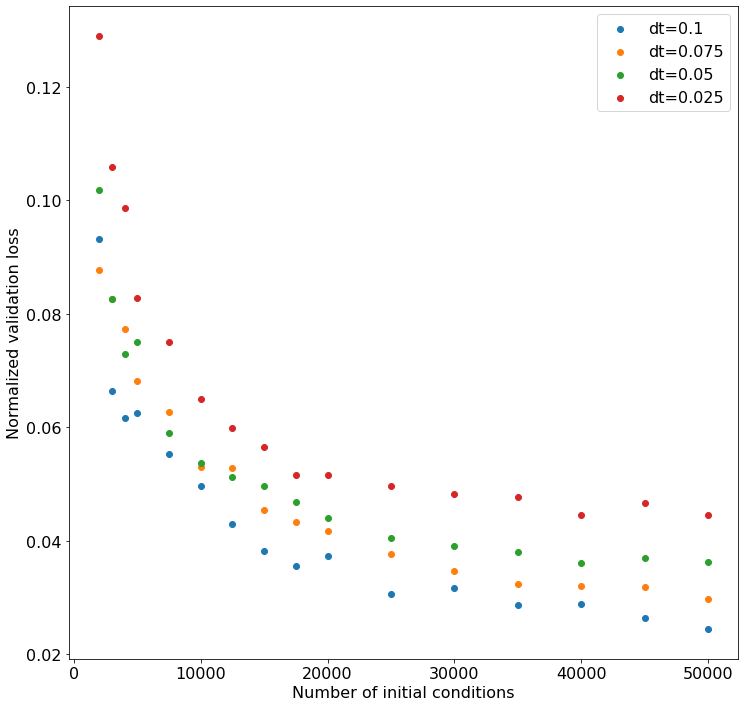

In [22]:
fig, ax = plt.subplots(figsize = (12,12))


TIMERANGE = 10

DATASETSIZES = (2000, 3000,4000,5000,7500,10000,12500,15000,17500, 20000, 25000,30000,35000,40000,45000,50000)

TIMESTEPS = (0.1,0.075,0.05,0.025)

for timestep in TIMESTEPS:
    losses = []
    for size in DATASETSIZES:
        strtime = str(timestep).replace('.','p')
        losses.append(normalized_val_loss('./dataspace_tests/datafiles/0t{}_dt{}_{}inits.data'.format(TIMERANGE, strtime,size),timestep))
    ax.scatter(DATASETSIZES,losses, label='dt='+str(timestep))
ax.legend()
ax.set_xlabel('Number of initial conditions')
ax.set_ylabel('Normalized validation loss')

In [110]:
#Create a 'graph' of memory usage for a given configuration
##We get about 5000000 points per 8GB of memory.  Not perfectly accurate, (tends to report high)
##but seems to be a pretty good approximation

import itertools

timesteps = [0.1,0.075,0.05,0.025,0.01,0.0075,0.005,0.0025,0.001]
initial_conditions = [2000,3000,4000,5000,7500,10000,12500,15000,17500,20000,25000,30000,35000,40000,45000,50000]
total_times = [5,10,15,20,25,50]

#timestep x initial conditions x total time
points = np.empty([len(total_times),len(initial_conditions),len(timesteps)])

for i,j,k in itertools.product(range(len(total_times)), range(len(initial_conditions)), range(len(timesteps))):
    points[i,j,k] = (total_times[i]/timesteps[k]) * initial_conditions[j]

In [125]:
GB = lambda x: (5000000/8)*x #Convert gigs to points (8GB is ~5000000 points)
points <= GB(64)

array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True, 

## Checking Nonlinearity

We want to check that $F^t[\phi(v)+\phi(w)]\neq F^t[\phi(v)] + F^t[\phi(w)]$.  To this end, we find triples $v,w,$ and $v+w$ such that $\phi(v),\phi(w),$ and $\phi(v)+\phi(w)$ are all in our training set to ensure that any inequality is due to nonlinearity rather than innacurate predictions.



In [30]:
def compress_evolution(evolution_path, save_path):
    evolution = np.genfromtxt(evolution_path, delimiter=',', skip_header=1)[:,1:]
    compressed_evolution = Phi(evolution).numpy()
    pd.DataFrame(compressed_evolution).to_csv(save_path)
    


In [240]:
datapath = '../../QuantumTeam/data/'
for i in range(5000):
    compress_evolution(datapath+'5000inits_dt0p1/evolution{}.csv'.format(i), datapath+'5000inits_dt0p1_compressed/evolution{}.csv'.format(i))

In [11]:
#Still quite slow, will take about 42 hours for the full 25000000 points

def get_sum_pair_triples(dataset, num_inits, start_init=0,epsilon=1e-2):
    valid_points = []
    for i in range(start_init,num_inits+start_init):
        k=0
        evolution = np.genfromtxt(dataset+'evolution{}.csv'.format(i), delimiter=',', skip_header=1)[:,1:]
        for v in evolution:
            vpws = evolution + v
            for vpw in vpws[k:]: 
                diff = np.linalg.norm(evolution-vpw, axis=-1)
                if (len(diff[diff<epsilon]) > 0):
                    w = vpw-v
                    vpwtilde = evolution[diff<epsilon][0]
                    valid_points.append([v[0], v[1], v[2], w[0], w[1], w[2], vpwtilde[0], vpwtilde[1], vpwtilde[2], i])
            k+=1
        if(i%200 == 0):
            print('Finished evolution {} of {}'.format(i-start_init,num_inits))
    return np.array(valid_points)


def read_sum_pair_triples(file,max_evolve,num_triples=-1):
    '''Reads in either num_triples (if specified) or all the triples
    from up to (and including) max_evolve, whichever is less.  If max_evolve
    is higher than the maximum evolution file, then we just return everything in the file
    (or num_triples, if specified)
    '''
    
    vs = np.genfromtxt(file, delimiter=',', skip_header=1, usecols=(1,2,3))
    ws = np.genfromtxt(file, delimiter=',', skip_header=1, usecols=(4,5,6))
    vpws = np.genfromtxt(file, delimiter=',', skip_header=1, usecols=(7,8,9))
    evolutions = np.genfromtxt(file,delimiter=',', skip_header=1, usecols=(10))
    
    max_triple = np.searchsorted(evolutions, max_evolve+1)
    if max_triple < num_triples or num_triples==-1:
        num_triples = max_triple
    
    return vs[:num_triples], ws[:num_triples], vpws[:num_triples]

In [10]:
%%time
valid_points = get_sum_pair_triples('../../QuantumTeam/data/50000inits_dt0p1_compressed/', 1000, start_init=6000)

Finished evolution 0 of 1000
Finished evolution 200 of 1000
Finished evolution 400 of 1000
Finished evolution 600 of 1000
Finished evolution 800 of 1000
CPU times: user 49min 21s, sys: 600 ms, total: 49min 21s
Wall time: 49min 50s


In [12]:
#pd.DataFrame(valid_points).to_csv('../../QuantumTeam/data/50000inits_dt0p1_sum_pair_triples/6t7000.csv')
#one = np.genfromtxt('../../QuantumTeam/data/50000inits_dt0p1_sum_pair_triples/6000.csv', delimiter=',', skip_header=1)[:,1:]
#two = np.genfromtxt('../../QuantumTeam/data/50000inits_dt0p1_sum_pair_triples/6t7000.csv', delimiter=',', skip_header=1)[:,1:]
#pd.DataFrame(np.concatenate((one,two))).to_csv('../../QuantumTeam/data/50000inits_dt0p1_sum_pair_triples/7000.csv')

vs, ws, vpws=read_sum_pair_triples('../../QuantumTeam/data/50000inits_dt0p1_sum_pair_triples/7000.csv', 3000)

In [13]:
%%time
nonlinearities = []
for j in (37,38,39):
    NonlinearEvolution = tf.keras.models.load_model('./models/trial{}e500.h5'.format(j), compile=False)
    avg = 0

    for i in range(len(vs)):
        vpw = np.array([vpws[i],])
        v = np.array([vs[i],])
        w = np.array([ws[i],])
        lhs = NonlinearEvolution(vpw).numpy()[0]
        rhs = NonlinearEvolution(v).numpy()[0] + NonlinearEvolution(w).numpy()[0]
        avg += np.linalg.norm(lhs-rhs)
    nonlinearities.append(avg/len(vs))

#print(avg/len(vs))

CPU times: user 27min 19s, sys: 36.1 s, total: 27min 55s
Wall time: 25min 41s


[0.06930090282137344, 0.06896808494860955, 0.06874874984385947]

### Old/unused functions

May still be useful as refrence/figure out what we were doing before, but not immidietley useful to the program and just cluttering up the notebook otherwise

In [186]:
##NOTE: The 2D compression tools do not work, only the 3D ones
def ideal_phi_2D(states):
    theta = np.math.atan2(states[1],states[0]) - np.math.atan2(states[3],states[2])
    r = np.sqrt(states[0]*states[0]+states[1]*states[1])
    return np.array([r, theta])

def ideal_phi_2D_inv(compressed):
    r, theta = compressed[0], compressed[1]
    
    alpha = r*np.cos(theta)
    beta = r*np.sin(theta)
    gamma = np.sqrt(1-r*r)
    delta = 0.
    return np.array([alpha, beta, gamma, delta])





#These compressions fail because sign information on the fourth dimension is lost w/ the square root

def ideal_phi_3D(states):
    return np.array([states[0], states[1], states[2]])

def ideal_phi_3D_inv(compressed):
    diff = 1-compressed[0]*compressed[0]-compressed[1]*compressed[1]-compressed[2]*compressed[2]
    if diff >=0.:
        fourth_component = np.sqrt(diff)
    else:
        fourth_component = 0.
    return np.array([compressed[0], compressed[1], compressed[2], fourth_component])


def get_relative_phase(vector):
    '''Returns the relative phase between
    the two complex components of a two
    complex dimensional vector
    Assumes the vector is passed in as a 
    four dimensional real row vector of form
    [real1, imag1, real2, imag2]
    '''
    

    #Tensorflow likes to return a list of a single
    #element sometimes, which breaks this function
    #This does not happen during training, only when
    #manually run on a single vector
    if vector.shape == (4,):
        return tf.atan2(vector[1], vector[0])%(2*np.pi) - tf.atan2(vector[3], vector[2])%(2*np.pi)

    return tf.atan2(vector[:,1],vector[:,0])%(2*np.pi) - tf.atan2(vector[:,3],vector[:,2])%(2*np.pi)


#We never train on just a single evolution anymore
def get_evolution_data(evolution_data, ideal_pre_compress_3D=False, pre_compress_phi=False):
    '''Read in evolution data from a csv file
    
    PARAMS:
    -------
    str evolution_data: Path to evolution datafile we wish to read
    bool ideal_pre_comrpess_3D: If true, uses ideal compression functions to 
                                  compress evolution data into specified dimension
    bool pre_compress_phi: If true, use the Phi neural net model to compress
                           evolution data
    
    RETURNS:
    --------
    tf.data.Dataset: Shuffled dataset of evolution values
    '''

    evolution_file = evolution_data
    
    with open(evolution_file, 'r') as f:
        data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
        
        if ideal_pre_compress_3D:
            data = np.array([ideal_phi_3D(x) for x in data])
        elif pre_compress_phi:
            data = Phi(data)
 
    
        pre_evolution = np.empty([len(data)-1, len(data[0])])
        post_evolution = np.empty([len(data)-1, len(data[0])])
   
        pre_evolution[0] = data[0]
        
        for i,k in enumerate(data[1:-1]):
            pre_evolution[i+1] = k
            post_evolution[i] = k
            
        post_evolution[-1] = data[-1]
        

        ds = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
            
        
        return ds.shuffle(100000, reshuffle_each_iteration=True)
    
    
    

#Some old keras Sequence generators
#Don't even know if these are still supported or not tbh
class evolution_training_data_generator(tf.keras.utils.Sequence):
    '''Sequence to load in dataset incrementally, rather than all at once.  evolution_training_data_generator and 
    evolution_validation_data_generator should take the same arguments
    
    PARAMS:
    -------
    
    str datadir - path containing the evolution{}.csv files
    
    int max_evolution - the largest evolution file to include in the dataset
                        NOTE: We read evolution0.csv through evolution{max_evolution-1}.csv, not
                              some random sample of evolution files (though the data from the ones
                              that we do select will be shuffled if shuffle is set True)
                              
    int training_evolutions - The number of evolution files which will be training data
                              NOTE: The first training_evolutions files will be the training data,
                                    not some shuffled sample
                                    
    int batch_size - The number of evolution files to include in a sample
                     This is not the number of points we are training on, but the number of 
                     evolution files.  500 timesteps per evolution and a batch size of 200 -> 100000
                     points per batch.  Batch size of 200 seems to be just about the max for 2GB of VRAM.
                     
    bool shuffle - Whether or not to shuffle the order in which we read our evolution files in
    bool pre_compress_phi - Whether or not to use Phi to compress our data right away.  Should pretty much always be True
    '''
    
    def __init__(self, datadir, max_evolution, training_evolutions, batch_size=200, shuffle=True, pre_compress_phi=True):
        self.datadir = datadir
        self.max_evolution = training_evolutions
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.pre_compress_phi=pre_compress_phi
        
        #Initilize the sampling indices
        self.on_epoch_end()
        
    #The indices essentially correspond to the 
    ##evolution files
    def on_epoch_end(self):
        self.indexes = np.arange(self.max_evolution)
        if (self.shuffle):
            np.random.shuffle(self.indexes)
            
    #This determines the number of batches per epoch
    def __len__(self):
        return int(np.floor(self.max_evolution / self.batch_size))
            
        
    #Index corresponds to batch number here, has no
    ##direct relation to self.indexes
    def __getitem__(self, index):
        pre_evolution = []
        post_evolution = []
        
        #Grab the batch size evolutions that we want
        indices = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
                
        
        #From here on, basically the same as get_multiple_evolutions
        for i in indices:
            with open(self.datadir+'evolution{}.csv'.format(i),'r') as f:
                data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
                
                if self.pre_compress_phi:
                    data = Phi(data)
                 
                #This was handled by the tf.dataset.shuffle in get_multiple_evolutions
                data = tf.random.shuffle(data)
                    
                pre_evolution.append(data[0])
                
                for k in data[1:-1]:
                    pre_evolution.append(k)
                    post_evolution.append(k)
                
                post_evolution.append(data[-1])
                    
        pre_evolution = tf.convert_to_tensor(pre_evolution)
        post_evolution = tf.convert_to_tensor(post_evolution)

        return pre_evolution, post_evolution
    
    
class evolution_validation_data_generator(tf.keras.utils.Sequence):
    
    def __init__(self, datadir, max_evolution, training_evolutions, batch_size=200, shuffle=True, pre_compress_phi=True):
        self.datadir = datadir
        self.max_evolution = max_evolution
        self.evolution_offset = training_evolutions
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.pre_compress_phi=pre_compress_phi
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.indexes = np.arange(self.evolution_offset,self.max_evolution)
        if (self.shuffle):
            np.random.shuffle(self.indexes)
            
    #Our data is batched in terms of initial conditions, so
    ##our length is based on the number of initial conditions used,
    ##not the raw number of points
    def __len__(self):
        return int(np.floor( (self.max_evolution-self.evolution_offset) / self.batch_size))
            
    def __getitem__(self, index):
        pre_evolution = []
        post_evolution = []
        
        #Grab the batch size evolutions that we want
        indices = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
                
        
        #From here on, basically the same as get_multiple_evolutions
        for i in indices:
            with open(self.datadir+'evolution{}.csv'.format(i),'r') as f:
                data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
                
                if self.pre_compress_phi:
                    data = Phi(data)
                    
                #This was handled by the tf.dataset.shuffle in get_multiple_evolutions
                data = tf.random.shuffle(data)
                    
                pre_evolution.append(data[0])
                
                for k in data[1:-1]:
                    pre_evolution.append(k)
                    post_evolution.append(k)
                
                post_evolution.append(data[-1])
                
        pre_evolution = tf.constant(pre_evolution)
        post_evolution = tf.constant(post_evolution)
        
        
        return pre_evolution, post_evolution

In [107]:
datadir = '../../QuantumTeam/data/50000inits_dt0p1_compressed/'
newfile = '../../QuantumTeam/data/master_test.csv'

with open(newfile, 'w') as fout:
    for i in range(50000):
        with open(datadir+'evolution{}.csv'.format(i), 'r') as fin:
            if i>0:
                next(fin)
                fout.write(fin.read())
            else:
                fout.write(fin.read())
